In [3]:
import matplotlib.pyplot as plt
import numpy as np
from my_cmaps import cmap
import hist
from hist.axis import Regular
from matplotlib import gridspec
from matplotlib.ticker import MaxNLocator
import seaborn as sns
from matplotlib import patches as mpatches
import matplotlib as mpl
n=100000
font = { "size": 18}#"family": "normal",
mpl.rc("font", **font)
FONTSIZE=20
def plot_hist(x,x_int,x_deq,name):
    fig = plt.figure(figsize=(6.4,8))

    outer_gs = gridspec.GridSpec(1, 1, figure=fig,hspace=0.3,wspace=.3)


    inner_gs = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=outer_gs[0], height_ratios=[4, 1], hspace=0.15
                                                )
    plt.rcParams['xtick.labelsize'] = 15  # for x-axis tick labels
    plt.rcParams['ytick.labelsize'] = 15
    # Create the main and ratio axes within the nested grid
    ax_main = fig.add_subplot(inner_gs[0])
    ax_ratio = fig.add_subplot(inner_gs[1], sharex=ax_main)

    real=hist.Hist(hist.axis.Regular(100,0,20))
    fake=hist.Hist(hist.axis.Regular(100,0,20))
    real.fill(x)
    fake.fill(x_deq)
    real.plot_ratio(fake, ax_dict={"main_ax":ax_main,"ratio_ax":ax_ratio},
                rp_ylabel=r"Ratio",
                bar_="blue",
                rp_denom_label="Dequantized Distribution",
                rp_num_label="Underlying Distribution",
                rp_uncert_draw_type="line", ) # line or bar)})
    ax_ratio.set_xlabel(r"z", fontsize=FONTSIZE)
    ax_main.set_ylabel("Counts", fontsize=FONTSIZE)
    ax_ratio.set_ylabel("Ratio", fontsize=FONTSIZE)
    ax_main.get_legend().remove()
    ax_ratio.set_ylim(0.5, 1.5)
    ax_main.set_xlabel("")
    ax_main.set_xticks([])
    ax_main.patches[0].set_fill(True)
    ax_main.ticklabel_format(axis="y", style="sci", scilimits=(-3, 3), useMathText=True)
    ax_ratio.ticklabel_format(axis="y", style="sci", scilimits=(-3, 3), useMathText=True)

    locator=MaxNLocator( nbins=6, prune="both")
    ax_main.yaxis.set_major_locator(locator)
    # ax_main.patches[1].set_fc(sns.color_palette()[0],alpha=0.3)
    # ax_main.patches[1].set_edgecolor("black")
    ax_main.patches[1].set_linewidth(2)
    ax_main.patches[0].set_alpha(0.3)
    ax_main.patches[0].set_lw(2)
    ax_ratio.set_xlim(ax_main.get_xlim())
    ax_main.legend(loc="best", fontsize=FONTSIZE)
    handles, labels = ax_main.get_legend_handles_labels()
    handles[1] = mpatches.Patch(color=sns.color_palette()[1], label="The red data")
    ax_main.legend(handles, labels,fontsize=FONTSIZE-5)
    ax_main.set_xticks([4,8,12,16])
    # plt.hist(x_int,bins=np.unique(x_int), label="Discretized Distribution",alpha=0.5,density=1)
    # _,bins,_=plt.hist(x,bins=100,label="Underlying Distribution",histtype='step',density=1)

    # plt.hist(x_deq,bins=bins, label="Dequantized Distribution",alpha=0.8,density=1);
    # plt.legend(fontsize=FONTSIZE-5)
    # plt.xlabel("z",fontsize=FONTSIZE)
    # plt.xticks(fontsize=FONTSIZE-5)
    # plt.yticks(fontsize=FONTSIZE-5)

    # plt.ylabel("p(z)",fontsize=FONTSIZE)
    # plt.yscale("log")
    import os
    os.makedirs("../plots/dequantization",exist_ok=True)
    plt.savefig(f'../plots/dequantization/{name}_dequantization.pdf',format='pdf',dpi=300)
    plt.show()
    plt.tight_layout()


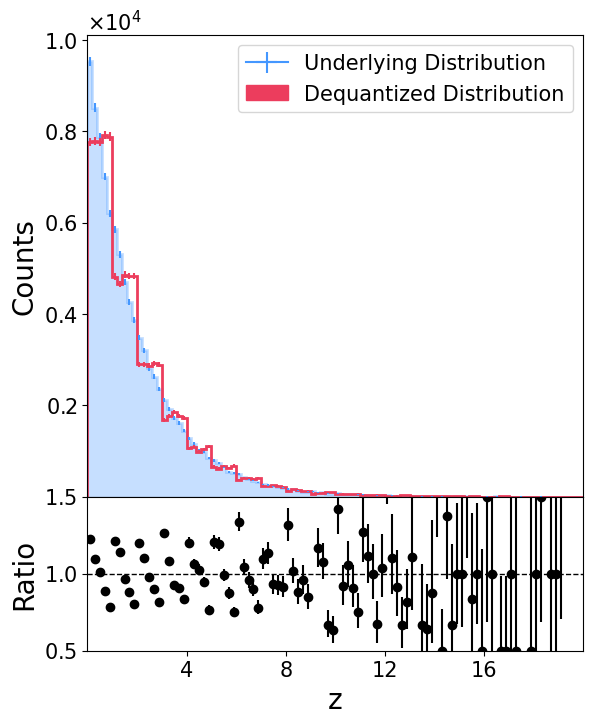

<Figure size 640x480 with 0 Axes>

In [5]:

x=np.random.gamma(1,2,n)
x=x[x<20]
x_int=np.floor(x)
x_deq=x_int+np.random.uniform(0,1,len(x))
plot_hist(x,x_int,x_deq,"uniform")

<Figure size 640x640 with 0 Axes>

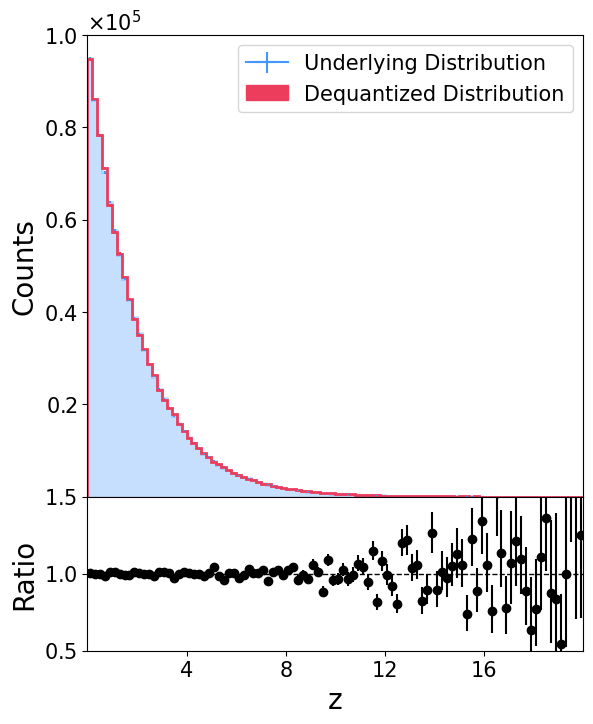

<Figure size 640x480 with 0 Axes>

In [8]:
from scipy.stats import rv_continuous
from sklearn.base import BaseEstimator, TransformerMixin

class DQLinear(BaseEstimator, TransformerMixin):
    #Linearly interpolate between bins, note that the forward transformation is very slow
    def __init__(self,name ):
        self.name=name
        pass
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):

        data = X.astype(int).reshape(-1)

        unique_values, counts = np.unique(data, return_counts=True)

        for j in range (len(unique_values)):
            # Select data points between this value and the next
            value,count = unique_values[j],counts[j]
            if j < len(unique_values)-1:
                nvalue,ncounts = unique_values[j+1],counts[j+1]

                lid=LinearInterpolatedDistribution(x0=count, x1=ncounts)

            mask = (X >= value) & (X < value + 1)

            samples=lid.rvs(sum(mask))

            X[mask]+=samples


        return X

    def inverse_transform(self, X, y=None):
        X = np.floor(X)
        return X
class LinearInterpolatedDistribution(rv_continuous):
    def __init__(self, x0, x1, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.x0 = x0
        self.x1 = x1
        self.s=self.x1-self.x0
        self.a = 0
        self.b = 1
        self._compute_normalization_constant()

    def _pdf(self, x):
        return 1/self.k*(self.x0 + self.s * x)

    def _compute_normalization_constant(self):
        self.k = (self.x1 + self.x0)*0.50

    def _cdf(self, x):
        return 1/self.k * ( self.x0 * x + 0.5 * (self.s) * x**2)

    def _ppf(self, q):

        a = 0.5*(self.s)
        b = self.x0
        c= -self.k*q
        discriminant = np.sqrt(b**2 - 4*a*c)
        root1 = ( discriminant - b) / (2*a+1e-5)

        # Use the root that falls within [0, 1]
        #results=np.where((root1 >= 0) & (root1 <= 1), root1, root2)
        return root1 #if (root1 >= 0 and root1 <= 1) else root2

    def rvs(self, size=None):
        u = np.random.uniform(size=size)
        return self._ppf(u)

n=1000000
plt.figure(figsize=(6.4,6.4))
FONTSIZE=20
x=np.random.gamma(1,2,n)
x=x[x<20]
x_int=np.floor(x)
deq=DQLinear("test")
x_deq=deq.fit_transform(np.copy(x_int.reshape(-1,1))).reshape(-1)
# x_deq=x_int+np.random.uniform(0,1,100000)
plot_hist(x,x_int,x_deq,"linear")

In [30]:

FONTSIZE=25
def plot_cal(x,x_uniform,x_int,name,feature=r"$z$"):
    fig = plt.figure(figsize=(12.8,6.4))


    outer_gs = gridspec.GridSpec(1, 1, figure=fig,hspace=0.3,wspace=.3)


    inner_gs = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=outer_gs[0],
                                                height_ratios=[4, 1], hspace=0
                                                )
    plt.rcParams['xtick.labelsize'] = 15  # for x-axis tick labels
    plt.rcParams['ytick.labelsize'] = 15
    # Create the main and ratio axes within the nested grid
    ax_ratio = fig.add_subplot(inner_gs[1])


    ax_main = fig.add_subplot(inner_gs[0])
    n=len(np.unique(x_int,return_counts=True)[0])

    real=hist.Hist(hist.axis.Regular(10*n,0,n))
    fake=hist.Hist(hist.axis.Regular(10*n,0,n))
    real.fill(x_uniform)
    fake.fill(x)

    real.plot_ratio(fake, ax_dict={"main_ax":ax_main,"ratio_ax":ax_ratio},
                rp_ylabel=r"Ratio",
                bar_="blue",
                rp_num_label="Uniform Dequantization",
                rp_denom_label="Linear Dequantization",
                rp_uncert_draw_type="line", ) # line or bar)})
    ax_ratio.set_xlabel(feature, fontsize=FONTSIZE)
    ax_main.set_ylabel("Counts", fontsize=FONTSIZE)
    ax_ratio.set_ylabel("Ratio", fontsize=FONTSIZE)
    ax_main.get_legend().remove()
    ax_ratio.set_ylim(0.5, 1.5)
    ax_main.set_xlabel("")

    ax_main.set_xticks([])
    ax_main.patches[0].set_fill(True)
    ax_main.ticklabel_format(axis="y", style="sci", scilimits=(-3, 3), useMathText=True)
    ax_ratio.ticklabel_format(axis="y", style="sci", scilimits=(-3, 3), useMathText=True)
    locator=MaxNLocator( nbins=6, prune="both")
    ax_main.yaxis.set_major_locator(locator)
    ax_main.patches[1].set_fc(sns.color_palette()[1])

    ax_main.patches[1].set_linewidth(2)
    ax_main.patches[0].set_alpha(0.3)
    ax_main.patches[0].set_lw(2)

    ax_main.legend(loc="best", fontsize=FONTSIZE)
    handles, labels = ax_main.get_legend_handles_labels()
    handles[1] = mpatches.Patch(color=sns.color_palette()[1], label="The red data")
    ax_main.legend(handles, labels,fontsize=FONTSIZE-5)
    ax_main.set_xlabel("")
    ax_ratio.set_xticks([0,10,20,30,40] if feature==r"$z$" else [2,4,6,8])
    ax_main.set_xlim(0,45 if feature==r"$z$" else 9)
    ax_ratio.set_xlim(ax_main.get_xlim())


    # plt.hist(x_int,bins=np.unique(x_int), label="Discretized Distribution",alpha=0.5,density=1)
    # _,bins,_=plt.hist(x,bins=100,label="Underlying Distribution",histtype='step',density=1)

    # plt.hist(x_deq,bins=bins, label="Dequantized Distribution",alpha=0.8,density=1);
    # plt.legend(fontsize=FONTSIZE-5)
    # plt.xlabel("z",fontsize=FONTSIZE)
    # plt.xticks(fontsize=FONTSIZE-5)
    # plt.yticks(fontsize=FONTSIZE-5)

    # plt.ylabel("p(z)",fontsize=FONTSIZE)
    # plt.yscale("log")
    plt.tight_layout()

    plt.savefig(f'plots/dequantization/{feature.replace("$","")}_dequantization.pdf',format='pdf',dpi=300)
    plt.show()


In [14]:
import torch
dataset="/beegfs/desy/user/kaechben/calochallenge/pc_train_middle.pt"
data=torch.load(dataset)
data=[x.reshape(-1,4) for x in data["E_z_alpha_r"]]
data=torch.cat(data)
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (MinMaxScaler, PowerTransformer,
                                   StandardScaler)
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import BatchSampler, DataLoader, Dataset
import sys
sys.path.append("/home/kaechben/MDMACalo/")
#from preprocess import ScalerBase,DQ,LogitTransformer
from utils.preprocess import (DQ, DQLinear, LogitTransformer, ScalerBase,
                            SqrtTransformer)
import os

os.chdir("/home/kaechben/MDMACalo/")
from utils.dataloader_calo import ScalerBase
name="middle"
scaler=ScalerBase(transfs=[],name=name,featurenames=["E","eta","phi","pt"],data_dir="./")
first_three_transforms = scaler.transfs[1].steps[1:]

# Creating a new pipeline with only the first three transformations
new_pipeline = Pipeline(first_three_transforms)

# Now you can use the inverse_transform method on this new pipeline
data = new_pipeline.inverse_transform(data[:,1:])

scaler_middle.gz
Scaler loaded


/tmp/ipykernel_25124/1907670020.py:72: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


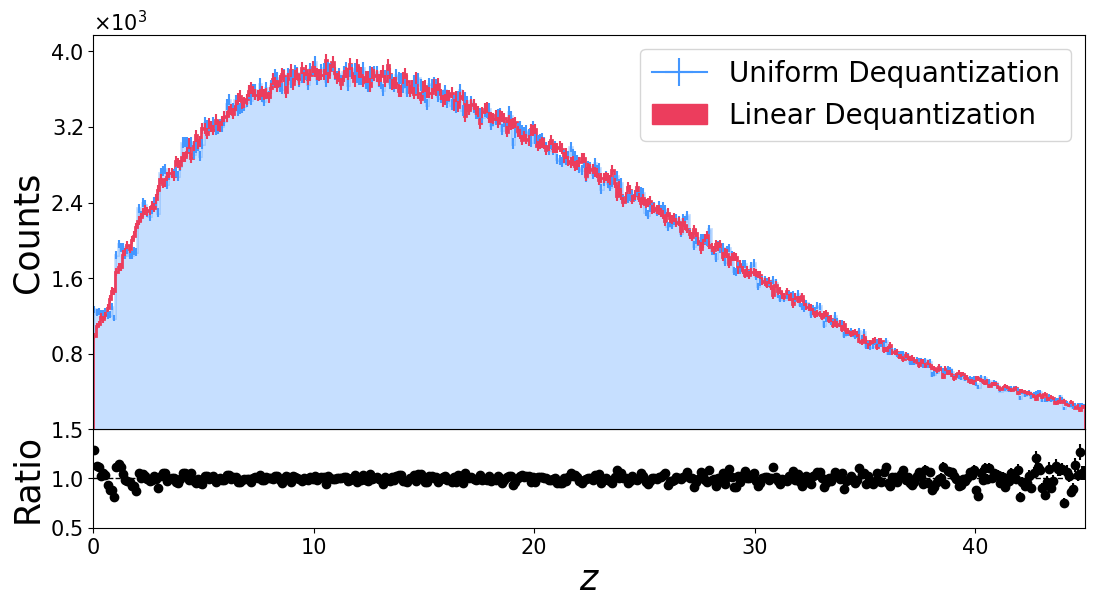

/tmp/ipykernel_25124/1907670020.py:72: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


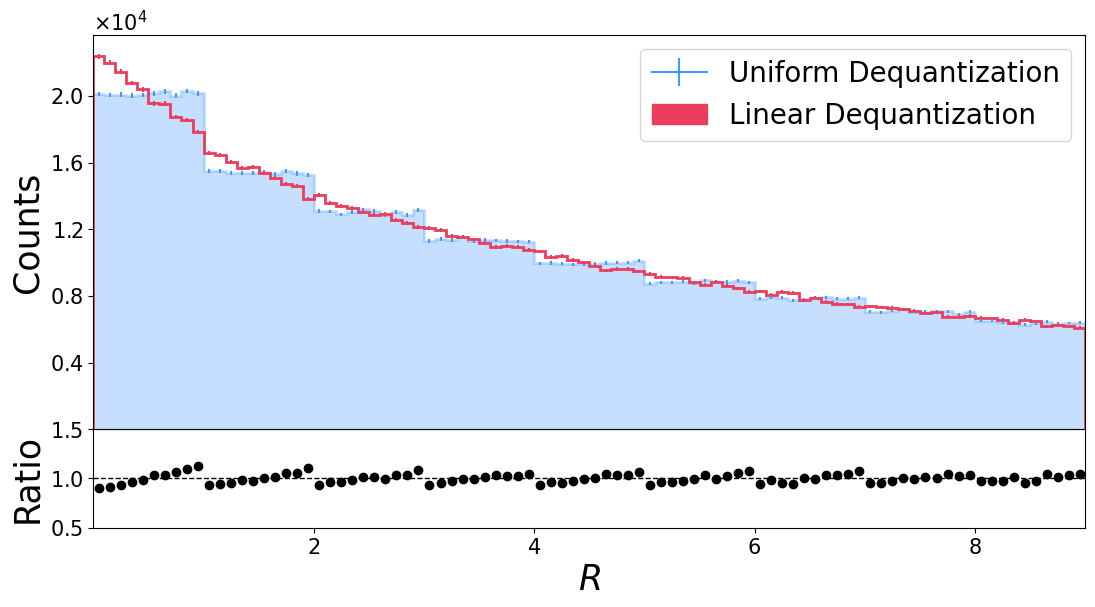

In [31]:
%matplotlib inline
for i,name in zip([0,2], [r"$z$",r"$R$"]):
    x=data[:1000000,i]
    x_int=np.floor(x)
    x_uniform=x_int+np.random.uniform(0,1,len(x))

    plot_cal(x,x_uniform,x_int,"calo_linear",name)